# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
#from scipy.misc import imresize
import PIL
import datetime
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
pip install keras

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
train_doc = np.random.permutation(open('gdrive/MyDrive/DataSets/ProjectData/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('gdrive/MyDrive/DataSets/ProjectData/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [6]:
print("Length of Training Data:",len(train_doc))
print("Length of Validation Data:",len(val_doc))

Length of Training Data: 663
Length of Validation Data: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [8]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [9]:
def generator(source_path, folder_list, batch_size,img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h = image.shape[0]
                    w = image.shape[1]
                    # if smaller image crop at center for 120x120
                    if w == 160:
                        image = image[:120, 20:140]
                    resize1 = skimage.transform.resize(image, (y,z))
                    modif=resize1/255.0
                    

                    batch_data[folder,idx,:,:,0] = modif[:, : , 0]
                    batch_data[folder,idx,:,:,1] = modif[:, : , 1]
                    batch_data[folder,idx,:,:,2] = modif[:, : , 2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                   
          # write the code for the remaining data points which are left after full batches
          # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            batch_size = len(folder_list)%batch_size
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h = image.shape[0]
                    w = image.shape[1]
                    # if smaller image crop at center for 120x120
                    if w == 160:
                        image = image[:120, 20:140]
                    resize1 = skimage.transform.resize(image, (y,z))
                    modif=resize1/255.0

                    batch_data[folder,idx,:,:,0] = modif[:, : , 0]
                    batch_data[folder,idx,:,:,1] = modif[:, : , 1]
                    batch_data[folder,idx,:,:,2] = modif[:, : , 2]
                      
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
          


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'gdrive/MyDrive/DataSets/ProjectData/Project_data/train'
val_path = 'gdrive/MyDrive/DataSets/ProjectData/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [11]:
sample_generator = generator(train_path, train_doc, batch_size,img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

Source path =  gdrive/MyDrive/DataSets/ProjectData/Project_data/train ; batch size = 10
(10, 20, 100, 100, 3)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### **BASE MODEL**

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Dropout,Activation,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [13]:
#write your model here
def Model_1(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
model=Model_1(img_tensor)
optimiser ='adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 48, 48, 16)     64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 23, 23, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 21, 21, 64)     5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size,img_tensor)
val_generator = generator(val_path, val_doc, batch_size,img_tensor)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4,cooldown=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


print ('steps_per_epoch %d' % steps_per_epoch)
print ('validation_steps %d' % validation_steps)

steps_per_epoch 67
validation_steps 10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
try:
    model1_history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

except ValueError as ex:
      print(ex)


Source path =  gdrive/MyDrive/DataSets/ProjectData/Project_data/train ; batch size = 10
Epoch 1/20
41/67 [=================>............] - ETA: 24:20 - loss: 2.2352 - categorical_accuracy: 0.3173

In [ ]:
def plottingModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Training loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Training accuracy vs Validation accuracy")
    plt.show()

    print('\033[1m',"Maximum Training Accuracy", round(max(h.history['categorical_accuracy'])*100,2),'%')
    print('\033[1m',"Maximum Validaiton Accuracy", round(max(h.history['val_categorical_accuracy'])*100,2),'%')

## With above observations, we can see that batch size is not impacting training time but number of frames. We will use batch size of 64 as it seems optimal. 

In [ ]:
#Model 2 - Frames-16, Epoc-20

n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size,img_tensor)
val_generator = generator(val_path, val_doc, batch_size,img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())


Model: "conv_3d2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 12, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 48, 48, 16)     64        
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 23, 23, 32)     128       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 21, 21, 64)     553

In [ ]:
model_2_history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5241 - categorical_accuracy: 0.4858Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-06-0704_08_41.722991/model-00001-1.52405-0.48580-2.51535-0.25000.h5
11/11 [==============================] - 70s 6s/step - loss: 1.5241 - categorical_accuracy: 0.4858 - val_loss: 2.5154 - val_categorical_accuracy: 0.2500
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.8718 - categorical_accuracy: 0.6759
Epoch 00002: saving model to model_init_2021-06-0704_08_41.722991/model-00002-0.87182-0.67589-3.47901-0.12500.h5
11/11 [==============================] - 32s 3s/step - loss: 0.8718 - categorical_accuracy: 0.6759 - val_loss: 3.4790 - val_categorical_accuracy: 0.1250
Epoch 3/20
11/11 [==============================] - ETA: 0s 

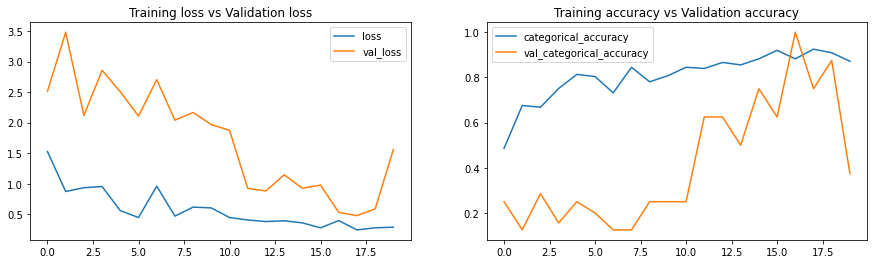

 Maximum Training Accuracy 92.51 %
 Maximum Validaiton Accuracy 100.0 %


In [ ]:
plottingModelHistory(model_2_history)

In [ ]:
#Model 3: Reducing Parameters, with Num of Frames-20,Batch Size 50   
n_frames = 20
num_epochs = 30
batch_size = 50

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size,img_tensor)
val_generator = generator(val_path, val_doc, batch_size,img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model_3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3.summary())

Model: "conv_3d3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 5, 25, 25, 64)     553

In [ ]:
model_3_history = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.3529 - categorical_accuracy: 0.5386Source path =  datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-06-0704_08_41.722991/model-00001-1.35294-0.53857-3.72685-0.24000.h5
14/14 [==============================] - 92s 7s/step - loss: 1.3529 - categorical_accuracy: 0.5386 - val_loss: 3.7269 - val_categorical_accuracy: 0.2400
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.8471 - categorical_accuracy: 0.6703
Epoch 00002: saving model to model_init_2021-06-0704_08_41.722991/model-00002-0.84707-0.67033-1.94622-0.30000.h5
14/14 [==============================] - 39s 3s/step - loss: 0.8471 - categorical_accuracy: 0.6703 - val_loss: 1.9462 - val_categorical_accuracy: 0.3000
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.8471 - categorical_accuracy: 0.6429
Epoch 00003: saving model to m

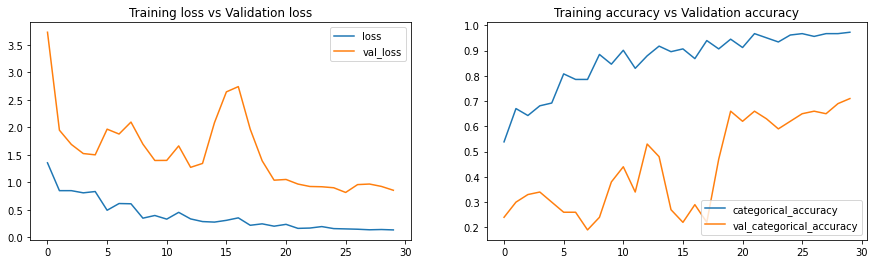

 Maximum Training Accuracy 97.25 %
 Maximum Validaiton Accuracy 71.0 %


In [ ]:
plottingModelHistory(model_3_history)

In [ ]:
#Model 4: Frames-20, Same pooling in Conv3D layer
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size,img_tensor)
val_generator = generator(val_path, val_doc, batch_size,img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),

    Dense(5, activation='softmax')
], name="conv_3d4")
model_4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4.summary())

Model: "conv_3d4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 5, 25, 25, 64)     553

In [ ]:
model_4_history = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 2.1655 - categorical_accuracy: 0.3651Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-06-0704_08_41.722991/model-00001-2.16553-0.36506-1.86414-0.21875.h5
11/11 [==============================] - 85s 8s/step - loss: 2.1655 - categorical_accuracy: 0.3651 - val_loss: 1.8641 - val_categorical_accuracy: 0.2188
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.4489 - categorical_accuracy: 0.4980
Epoch 00002: saving model to model_init_2021-06-0704_08_41.722991/model-00002-1.44886-0.49802-2.05844-0.26389.h5
11/11 [==============================] - 39s 4s/step - loss: 1.4489 - categorical_accuracy: 0.4980 - val_loss: 2.0584 - val_categorical_accuracy: 0.2639
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.5238 - categorical_accuracy: 0.5020
Epoch 00003: saving model to m

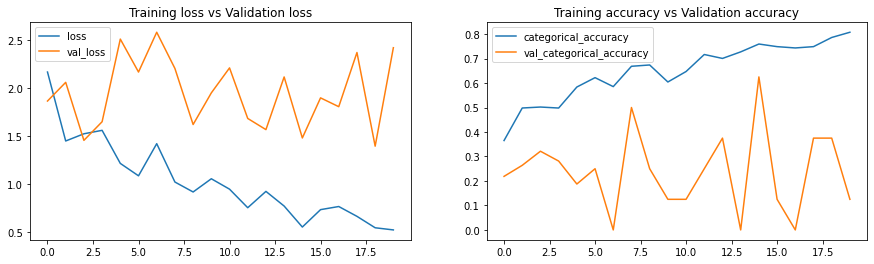

 Maximum Training Accuracy 80.75 %
 Maximum Validaiton Accuracy 62.5 %


In [ ]:
plottingModelHistory(model_4_history)

In [ ]:
#Model 5: Frames-20, Same pooling in Conv3D layer
n_frames = 20
num_epochs = 40
batch_size = 50

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size,img_tensor)
val_generator = generator(val_path, val_doc, batch_size,img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_5 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d5")
model_5.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_5.summary())

Model: "conv_3d5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 5, 25, 25, 64)     553

In [ ]:
model_5_history = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 50
Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 1.5723 - categorical_accuracy: 0.4471Source path =  datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-06-0704_08_41.722991/model-00001-1.57228-0.44714-1.50144-0.28000.h5
14/14 [==============================] - 92s 7s/step - loss: 1.5723 - categorical_accuracy: 0.4471 - val_loss: 1.5014 - val_categorical_accuracy: 0.2800
Epoch 2/40
14/14 [==============================] - ETA: 0s - loss: 1.3414 - categorical_accuracy: 0.5604
Epoch 00002: saving model to model_init_2021-06-0704_08_41.722991/model-00002-1.34144-0.56044-1.58253-0.37000.h5
14/14 [==============================] - 39s 3s/step - loss: 1.3414 - categorical_accuracy: 0.5604 - val_loss: 1.5825 - val_categorical_accuracy: 0.3700
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 1.0038 - categorical_accuracy: 0.6209
Epoch 00003: saving model to m

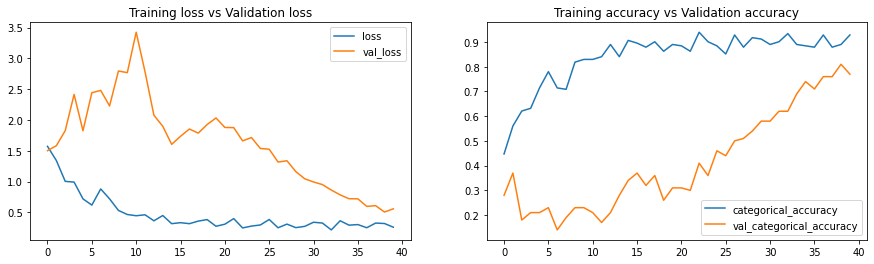

 Maximum Training Accuracy 93.96 %
 Maximum Validaiton Accuracy 81.0 %


In [ ]:
plottingModelHistory(model_5_history)

In [ ]:
#Model 6: Frames:20, Epocs-40, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling.
n_frames = 20
num_epochs = 40
batch_size = 50

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size,img_tensor)
val_generator = generator(val_path, val_doc, batch_size,img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_6 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    
    Dense(5, activation='softmax')
], name="conv_3d6")
model_6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())


Model: "conv_3d6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 20, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_27 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_28 (Batc (None, 10, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 5, 25, 25, 64)     164

In [ ]:
model_6_history = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 50
Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 2.7545 - categorical_accuracy: 0.4129Source path =  datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-06-0704_08_41.722991/model-00001-2.75448-0.41286-1.53836-0.33000.h5
14/14 [==============================] - 97s 7s/step - loss: 2.7545 - categorical_accuracy: 0.4129 - val_loss: 1.5384 - val_categorical_accuracy: 0.3300
Epoch 2/40
14/14 [==============================] - ETA: 0s - loss: 1.2688 - categorical_accuracy: 0.5495
Epoch 00002: saving model to model_init_2021-06-0704_08_41.722991/model-00002-1.26883-0.54945-2.56200-0.25000.h5
14/14 [==============================] - 41s 3s/step - loss: 1.2688 - categorical_accuracy: 0.5495 - val_loss: 2.5620 - val_categorical_accuracy: 0.2500
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 0.8004 - categorical_accuracy: 0.7088
Epoch 00003: saving model to m

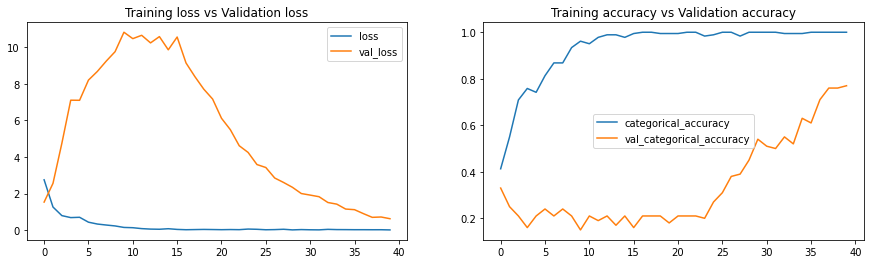

 Maximum Training Accuracy 100.0 %
 Maximum Validaiton Accuracy 77.0 %


In [ ]:
plottingModelHistory(model_6_history)

In [ ]:
#Model 7: Switching Model architecture to Conv2D+LSTM
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model_7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_7.summary())



Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 25, 25, 64)   

In [ ]:
model_7_history = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3758 - categorical_accuracy: 0.4717Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2021-06-0704_08_41.722991/model-00001-1.37583-0.47173-1.81653-0.21875.h5
21/21 [==============================] - 91s 4s/step - loss: 1.3758 - categorical_accuracy: 0.4717 - val_loss: 1.8165 - val_categorical_accuracy: 0.2188
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9448 - categorical_accuracy: 0.6335
Epoch 00002: saving model to model_init_2021-06-0704_08_41.722991/model-00002-0.94481-0.63354-1.83065-0.18750.h5
21/21 [==============================] - 62s 3s/step - loss: 0.9448 - categorical_accuracy: 0.6335 - val_loss: 1.8307 - val_categorical_accuracy: 0.1875
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9411 - categorical_accuracy: 0.6450
Epoch 00003: saving model to m

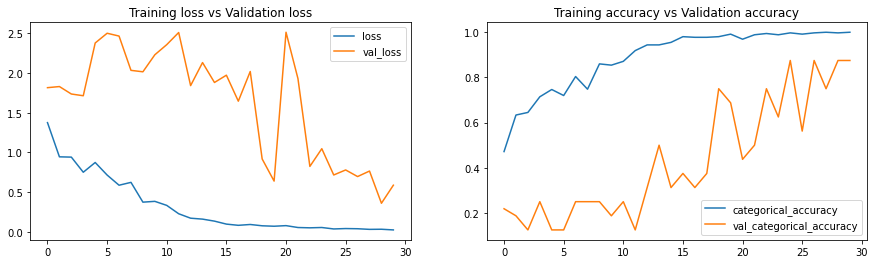

 Maximum Training Accuracy 100.0 %
 Maximum Validaiton Accuracy 87.5 %


In [ ]:
plottingModelHistory(model_7_history)